In [95]:
from bs4 import BeautifulSoup
from dateutil.parser import parse
from datetime import datetime
from datetime import datetime, timedelta
import urlparse
import pymongo 
from pymongo import MongoClient
import os

In [96]:
connection = MongoClient()
db = connection['espn_leagues_drafts']
auction_drafts = db['auction_drafts']
league_settings = db['league_settings']

In [97]:
print 'auction draft picks:',auction_drafts.count()
auction_drafts.find_one()

auction draft picks: 2370380


{u'_id': ObjectId('5696f378c807ee40f02d507e'),
 u'league_id': u'100005',
 u'nom_order': 16,
 u'player_id': u'4529',
 u'player_name': u'Yu Darvish',
 u'player_name_id': u'Yu Darvish (4529)',
 u'price': 1,
 u'season_id': u'2015',
 u'team_id': u'1',
 u'team_name': u'LEAGUE CHAMPION',
 u'unique_team_id': u'-2147483648'}

In [98]:
print 'auction drafts collected/stored:', len(auction_drafts.distinct("league_id"))

auction drafts collected/stored: 9359


In [99]:
league_settings.find_one()

{u'2015 Keeper Lock Date': u'Lock One Hour Before Draft',
 u'2015 Keepers Per Team': u'None',
 u'2016 Keeper Lock Date': u'Lock One Hour Before Draft',
 u'2016 Keepers Per Team': u'None',
 u'Allow Draft Pick Trading': u'Yes',
 u'Auction Budget': u'0',
 u'Current Roster Size': u' 20',
 u'Draft Date': u'Sunday, March 29, 2015 at 8:15 PM ET',
 u'Draft Order': u'Manually Set by League Manager',
 u'Draft Type': u'Snake',
 u'Format': u'League Manager',
 u'Keeper Note': u'',
 u'League Name': u"MLW (Malibu's Least Wanted)",
 u'Location': u'',
 u'Make League Viewable to Public': u'Yes',
 u'Note': u'',
 u'Number of Teams': u'12',
 u'Scoring Type': u'Head to Head Each Category',
 u'Seconds Per Pick': u'60',
 u'Total On Bench': u' 5 (2 DL)',
 u'Total Starters': u' 15',
 u'Use Keepers for 2015 Season': u'No',
 u'Use Keepers for 2016 Season': u'No',
 u'_id': ObjectId('5696ea45c807ee4d9977fd18'),
 u'league_id': u'10000',
 u'positions': {u'1B': u'1',
  u'2B': u'1',
  u'3B': u'1',
  u'BE': u'5',
  u'C'

In [100]:
league_settings.group(["Format"], {}, {"count":0},"function(o, p){p.count++}" )

[{u'Format': u'League Manager', u'count': 19409.0},
 {u'Format': u'Standard', u'count': 30421.0},
 {u'Format': u'ESPN Custom', u'count': 20320.0}]

In [101]:
league_settings.group(["Scoring Type"], {}, {"count":0},"function(o, p){p.count++}" )

[{u'Scoring Type': u'Head to Head Each Category', u'count': 23428.0},
 {u'Scoring Type': u'Rotisserie', u'count': 18799.0},
 {u'Scoring Type': u'Head to Head Points', u'count': 22658.0},
 {u'Scoring Type': u'Head to Head Most Categories', u'count': 3886.0},
 {u'Scoring Type': u'Total Season Points', u'count': 1379.0}]

In [102]:
league_settings.group(["Draft Type"], {}, {"count":0},"function(o, p){p.count++}" )

[{u'Draft Type': u'Snake', u'count': 54688.0},
 {u'Draft Type': u'Auction', u'count': 9359.0},
 {u'Draft Type': u'Autopick', u'count': 3666.0},
 {u'Draft Type': u'Offline', u'count': 2436.0},
 {u'Draft Type': None, u'count': 1.0}]

In [103]:
league_settings.group(["Number of Teams"], {}, {"count":0},"function(o, p){p.count++}" )

[{u'Number of Teams': u'12', u'count': 6715.0},
 {u'Number of Teams': u'10', u'count': 46598.0},
 {u'Number of Teams': u'8', u'count': 6926.0},
 {u'Number of Teams': u'14', u'count': 935.0},
 {u'Number of Teams': u'20', u'count': 694.0},
 {u'Number of Teams': u'6', u'count': 2941.0},
 {u'Number of Teams': u'16', u'count': 814.0},
 {u'Number of Teams': u'4', u'count': 3000.0},
 {u'Number of Teams': u'5', u'count': 359.0},
 {u'Number of Teams': u'9', u'count': 320.0},
 {u'Number of Teams': u'13', u'count': 95.0},
 {u'Number of Teams': u'15', u'count': 133.0},
 {u'Number of Teams': u'7', u'count': 258.0},
 {u'Number of Teams': u'11', u'count': 262.0},
 {u'Number of Teams': u'18', u'count': 87.0},
 {u'Number of Teams': u'17', u'count': 12.0},
 {u'Number of Teams': u'19', u'count': 1.0}]

In [104]:
league_settings.group(["Use Keepers for 2015 Season"], {}, {"count":0},"function(o, p){p.count++}" )

[{u'Use Keepers for 2015 Season': u'No', u'count': 62199.0},
 {u'Use Keepers for 2015 Season': u'Yes', u'count': 7950.0},
 {u'Use Keepers for 2015 Season': None, u'count': 1.0}]

In [105]:
auction_standard_10team_league_ids = list(league_settings.find({"Draft Type":"Auction","Number of Teams":"10",
                                                         "Format":"Standard",
               "Auction Budget":"260","Scoring Type":"Rotisserie",
               "Use Keepers for 2015 Season":"No"},{"_id":0,"league_id":1}))

auction_standard_10team_league_ids =[d['league_id'] for d in auction_standard_10team_league_ids]
print len(auction_standard_10team_league_ids)
#auction_standard_10team_league_ids

2478


In [111]:
auction_drafts = db['auction_drafts']
pipe = [{'$match':{'league_id':{'$in': auction_standard_10team_league_ids}}},
        { '$out' : "standard_auction_10team_roto_picks" }]

auction_drafts.aggregate(pipeline=pipe)
standard_auction_10team_roto_picks = db['standard_auction_10team_roto_picks']
standard_auction_10team_roto_picks.count()

619500

In [115]:
pipe = [{'$group':{'_id':'$player_name_id','total':{'$sum':1},'avg_price':{'$avg':'$price'}}},
        { '$sort' : { 'total':-1} },
        { '$out' : "auction_standard_10team_avg_prices" }
        ]

standard_auction_10team_roto_picks.aggregate(pipeline=pipe)

auction_standard_10team_avg_prices = db['auction_standard_10team_avg_prices']
auction_standard_10team_avg_prices.count()

1022

In [117]:
auction_standard_10team_avg_prices.find_one()

{u'_id': u'Gregory Polanco (5447)',
 u'avg_price': 6.094430992736077,
 u'total': 2478}

In [108]:
# for player in auction_standard_10team_avg_prices.find()[:500]:
#     print player

In [109]:
# pipe = [{'$match':{'player_id':'3280'}},
#         { '$out' : "mike_trout_standard_auction_10team_roto_picks" }]

# standard_auction_10team_roto_picks.aggregate(pipeline=pipe)
# mike_trout_standard_auction_10team_roto_picks = db['mike_trout_standard_auction_10team_roto_picks']
# #mike_trout_standard_auction_10team_roto_picks.count()
# pipe = [{'$group':{'_id':'$nom_order','total':{'$sum':1},'avg_price':{'$avg':'$price'}}},
#         { '$sort' : { '_id':1} }
#         ]
# list(mike_trout_standard_auction_10team_roto_picks.aggregate(pipeline=pipe))

In [110]:
# pipe = [{'$match':{'player_id':'1870'}},
#         { '$out' : "scherz_standard_auction_10team_roto_picks" }]

# standard_auction_10team_roto_picks.aggregate(pipeline=pipe)
# scherz_standard_auction_10team_roto_picks = db['scherz_standard_auction_10team_roto_picks']
# #mike_trout_standard_auction_10team_roto_picks.count()
# pipe = [{'$group':{'_id':'$nom_order','total':{'$sum':1},'avg_price':{'$avg':'$price'}}},
#         { '$sort' : { '_id':1} }
#         ]
# list(scherz_standard_auction_10team_roto_picks.aggregate(pipeline=pipe))

In [119]:
import pandas as pd
%matplotlib inline

In [120]:
df = pd.DataFrame(list(standard_auction_10team_roto_picks.find()))

In [124]:
df['player_id_avg_price'] = df['price'].groupby(df['player_id']).transform('mean')
df['player_id_med_price'] = df['price'].groupby(df['player_id']).transform('median')

df["value_over_mean"] = df["player_id_avg_price"] - df["price"]
df["value_over_median"] = df["player_id_med_price"] - df["price"]

df['nom_avg_value_mean'] = df['value_over_mean'].groupby(df['nom_order']).transform('mean')
df['nom_avg_value_median'] = df['value_over_median'].groupby(df['nom_order']).transform('mean')

df

,_id,league_id,nom_order,player_id,player_name,player_name_id,price,season_id,team_id,team_name,unique_team_id,player_id_avg_price,player_id_med_price,value_over_mean,value_over_median,nom_avg_value_mean,nom_avg_value_median
0,5696f378c807ee40f02d52a4,100062,46,1870,Max Scherzer,Max Scherzer (1870),25,2015,6,TEAM SCOTT,-2147483648,25.675545,25,0.675545,0,-0.540421,-0.863600
1,5696f378c807ee40f02d52a5,100062,47,3548,Alex Cobb,Alex Cobb (3548),14,2015,6,TEAM SCOTT,-2147483648,10.807910,10,-3.192090,-4,-0.600977,-0.916868
2,5696f378c807ee40f02d52a6,100062,51,1864,David Price,David Price (1864),23,2015,6,TEAM SCOTT,-2147483648,21.227199,21,-1.772801,-2,-0.444193,-0.751211
3,5696f378c807ee40f02d52a7,100062,57,613,Albert Pujols,Albert Pujols (613),17,2015,6,TEAM SCOTT,-2147483648,16.559726,16,-0.440274,-1,-0.467212,-0.777643
4,5696f378c807ee40f02d52a8,100062,67,3898,Kole Calhoun,Kole Calhoun (3898),14,2015,6,TEAM SCOTT,-2147483648,12.569411,13,-1.430589,-1,-0.362780,-0.658394
5,5696f378c807ee40f02d52a9,100062,71,1581,Evan Longoria,Evan Longoria (1581),18,2015,6,TEAM SCOTT,-2147483648,16.572639,16,-1.427361,-2,-0.373250,-0.650928
6,5696f378c807ee40f02d52aa,100062,74,4553,Yoenis Cespedes,Yoenis Cespedes (4553),16,2015,6,TEAM SCOTT,-2147483648,15.650928,16,-0.349072,0,-0.340394,-0.592413
7,5696f378c807ee40f02d52ab,100062,78,1600,Carlos Gonzalez,Carlos Gonzalez (1600),23,2015,6,TEAM SCOTT,-2147483648,17.086360,16,-5.913640,-7,-0.381734,-0.624294
8,5696f378c807ee40f02d52ac,100062,90,2009,Jeff Samardzija,Jeff Samardzija (2009),11,2015,6,TEAM SCOTT,-2147483648,13.817595,14,2.817595,3,-0.331824,-0.533091
9,5696f378c807ee40f02d52ad,100062,101,2025,Pablo Sandoval,Pablo Sandoval (2025),9,2015,6,TEAM SCOTT,-2147483648,8.371267,8,-0.628733,-1,-0.340300,-0.497175


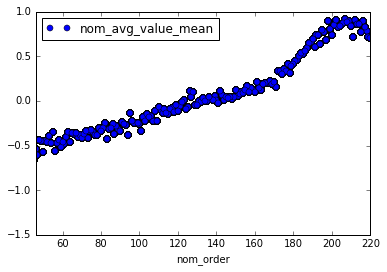

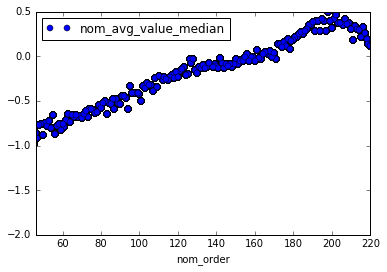

In [125]:
df.plot(x='nom_order', y='nom_avg_value_mean', style='o')
df.plot(x='nom_order', y='nom_avg_value_median', style='o')

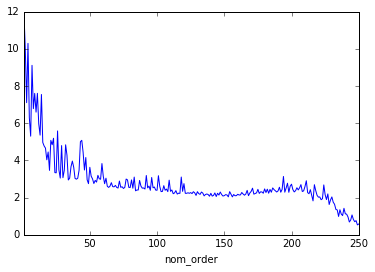

In [46]:
std = df.groupby(['nom_order']).std()
std["value"].plot()